# Adaptation of Hvass-Lab's Tensorflow/Keras Image Catpioning Tutorial
[Original Tutorial](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb)

In [8]:
#@title Notebook Params

#@markdown ### Data Params
download_data = True #@param {type: "boolean"}
data_dir = '/data'
image_dir = f'{data_dir}/images'

#@markdown ### Tokenizer Params
mark_start = 'ssss ' #@param {type: "string"}
mark_end = ' eeee'   #@param {type: "string"}
num_words = 10000 #@param {type: "number"}

#@markdown ### RNN Model Params
state_size = 512 #@param {type: "number"}
embedding_size = 128 #@param {type: "number"}

images_batch_size = 16 #@param {type: "number"}
batch_size =  512 #@param {type: "number"}
epochs = 20 #@param {type: "number"}
steps_per_epoch = 1000 #@param {type: "number"}

#@markdown ### Dataset Size Params
#@markdown Dataset size values of 0 will use the whole dataset
train_set_size =  100 #@param {type: "number"}
val_set_size =  100#@param {type: "number"}

## Install and Import Libraries

In [9]:
# Install the coco utils library and its dependencies.
!pip install pycocotools

In [10]:
import os
from tqdm.notebook import tqdm

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import skimage.io as io
from PIL import Image
from pycocotools.coco import COCO

In [11]:
# Are we running on GPU?
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
# Allow Tensorflow/Keras to use more GPU memory
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Download and Load COCO Dataset

In [13]:
# Download and extract the dataset
def download_and_extract(file_name_no_extension, dest_dir=None, data_dir='.', sub_path='zips'):
    '''Download and extract zip files if they haven't been already.
    '''
    print(f'Downloading {file_name_no_extension}.zip')
    !wget --timestamping -c -P {data_dir} http://images.cocodataset.org/{sub_path}/{file_name_no_extension}.zip 
    if dest_dir:
        !mkdir -p {dest_dir}
        print(f'Extracting {file_name_no_extension}.zip to {dest_dir}')
        !unzip -uojq {data_dir}/{file_name_no_extension}.zip -d {dest_dir}
    else:
        print(f'Extracting {file_name_no_extension}.zip to {data_dir}')
        !unzip -uoq {data_dir}/{file_name_no_extension}.zip -d {data_dir}

In [14]:
# Download and extract the dataset if we haven't already
if download_data:
    download_and_extract('annotations_trainval2017', data_dir=data_dir, sub_path='annotations')
    download_and_extract('train2017', dest_dir=image_dir, data_dir=data_dir)
    download_and_extract('val2017', dest_dir=image_dir, data_dir=data_dir)
    print('Done!')

--2020-02-22 23:46:27--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.109.19
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.109.19|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/data/annotations_trainval2017.zip’ not modified on server. Omitting download.

Extracting annotations_trainval2017.zip to /data
--2020-02-22 23:46:27--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.109.19
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.109.19|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/data/train2017.zip’ not modified on server. Omitting download.

Extracting train2017.zip to /data/images
--2020-02-22 23:46:28--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)..

In [15]:
# Load the coco dataset using coco tools python library
coco_train = COCO(f'{data_dir}/annotations/captions_train2017.json')
coco_val = COCO(f'{data_dir}/annotations/captions_val2017.json')

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [16]:
# Get train and validation img_id sets
train_img_ids_full = coco_train.getImgIds()
val_img_ids_full = coco_val.getImgIds()
# Take a subset of img_ids if 0 is not specified as the dataset size
train_img_ids = (train_img_ids_full if train_set_size == 0 
                 else train_img_ids_full[:train_set_size])
val_img_ids = (val_img_ids_full if val_set_size == 0 
                 else val_img_ids_full[:val_set_size])

## Create Model That Understands Images

In [17]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """
    img = Image.open(path)
    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)
    img = np.array(img)
    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0
    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [18]:
def show_images(img_ids, coco, image_dir):
    img_props_list = coco.loadImgs(img_ids)

    for img_props in img_props_list: 
        img = load_image(os.path.join(image_dir, img_props['file_name']))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

        ann_ids = coco.getAnnIds(imgIds=img_props['id'])
        anns = coco.loadAnns(ann_ids)
        coco.showAnns(anns)

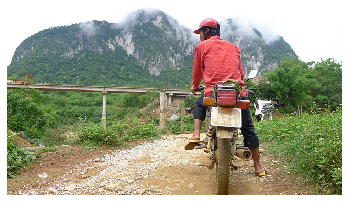

A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.


In [19]:
# Let's show an image and the caption!
show_images(train_img_ids[0], coco_train, image_dir)

In [20]:
# Load our pretrained model for 'understanding' images
image_model = VGG16(include_top=True, weights='imagenet')

In [21]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
# Drop the last layer (prediction layer) from the image model
# since we are going to use this model as part of our larger model
# and not for prediction directly (transfer learning)
transfer_layer = image_model.get_layer('fc2')
image_transer_model = Model(inputs=image_model.input,
                            outputs=transfer_layer.output)

In [23]:
# Get the expected size in pixels for an image that is fed into the model.
img_size = K.int_shape(image_model.input)[1:3]
print(img_size)

(224, 224)


In [24]:
# Get the size of the output layer.
transfer_values_size = K.int_shape(transfer_layer.output)[1]
print(transfer_values_size)

4096


In [25]:
def create_batches(l, batch_size):
    for idx in range(0, len(l), batch_size):
        yield l[idx:idx+batch_size]

In [26]:
def process_images(img_ids, image_dir,
                   coco, model, batch_size=32,
                   img_size=(224,224), transfer_size=4096):
    num_images = len(img_ids)
    img_shape = (batch_size,) + img_size + (3,)
    img_batch = np.zeros(shape=img_shape, dtype=np.float16)
    transfer_shape = (num_images, transfer_size)
    transfer_values = np.zeros(shape=transfer_shape, dtype=np.float16)
    img_id_batches = create_batches(img_ids, batch_size)
    start_index = 0
    for img_id_batch in tqdm(img_id_batches):
        img_props_batch = coco.loadImgs(ids=img_id_batch)
        # The size of the current batch can be less than batch_size
        # if the dataset doesn't devide evenly into batch_size
        current_batch_size = len(img_props_batch)
        for idx, img_props in enumerate(img_props_batch):
            img_batch[idx] = load_image(
                                os.path.join(image_dir, img_props['file_name']),
                                size=img_size)

        transfer_values_batch = model.predict(img_batch[0:current_batch_size])
        transfer_values[start_index:start_index + current_batch_size] = (
            transfer_values_batch[0:current_batch_size]
        )

        start_index += current_batch_size

    return transfer_values

In [27]:
transfer_values = process_images(
                        train_img_ids,
                        image_dir,
                        coco_train,
                        image_transer_model,
                        batch_size=images_batch_size)
transfer_values[0]

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv1/Conv2D (defined at <ipython-input-26-a9bc93f9f6fd>:21) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_644]

Function call stack:
distributed_function


## Create Model to Produce Captions

In [ ]:
def get_captions(coco, img_ids):
    anns_ids = coco.getAnnIds(imgIds=img_ids)
    anns = coco.loadAnns(ids=anns_ids)
    captions = []
    for img_id in img_ids:
        anns_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ids=anns_ids)
        captions.append([ann['caption'] for ann in anns])
    return captions

In [ ]:
captions_train = get_captions(coco_train, train_img_ids)
captions_train[0]

In [ ]:
def mark_captions(captions, mark_start='ssss ', mark_end=' eeee'):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_for_one_img]
                        for captions_for_one_img in captions]
    return captions_marked

In [ ]:
captions_train_marked = mark_captions(captions_train,
                                      mark_start,
                                      mark_end)
captions_train_marked[0]

In [ ]:
def flatten(captions):
    captions_flat = [caption
                     for captions_for_one_img in captions
                     for caption in captions_for_one_img]
    return captions_flat

In [ ]:
captions_train_flat = flatten(captions_train_marked)
captions_train_flat[:5]

In [ ]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """
        super().__init__(num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [ ]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words=num_words)

In [ ]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

In [ ]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

In [ ]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

In [ ]:
def get_random_caption_tokens(img_indices, tokens):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption for each image,
    and return a list of all these token-sequences.
    """
    result = []
    for img_index in img_indices:
        caption_index = np.random.choice(len(tokens[img_index]))
        random_tokens = tokens[img_index][caption_index]
        result.append(random_tokens)
    return result

In [ ]:
def batch_generator(num_images, transfer_values, tokens, batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        random_img_indices = np.random.randint(num_images, size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        tv = transfer_values[random_img_indices]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        random_tokens = get_random_caption_tokens(random_img_indices, tokens)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in random_tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(random_tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': tv
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [ ]:
generator = batch_generator(
                num_images=len(train_img_ids),
                transfer_values=transfer_values,
                tokens=tokens_train,
                batch_size=batch_size)

In [ ]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [ ]:
batch_x['transfer_values_input'][0]

In [ ]:
batch_x['decoder_input'][0]

In [ ]:
batch_y['decoder_output'][0]

In [ ]:
def create_decoder_model(transfer_values_size,
                         state_size,
                         embedding_size,
                         num_words):
    # Define the layers
    transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

    decoder_transfer_map = Dense(state_size,
                                activation='tanh',
                                name='decoder_transfer_map')

    decoder_input = Input(shape=(None, ), name='decoder_input')

    decoder_embedding = Embedding(input_dim=num_words,
                                output_dim=embedding_size,
                                name='decoder_embedding')

    decoder_gru1 = GRU(state_size, name='decoder_gru1',
                    return_sequences=True)
    decoder_gru2 = GRU(state_size, name='decoder_gru2',
                    return_sequences=True)
    decoder_gru3 = GRU(state_size, name='decoder_gru3',
                    return_sequences=True)

    # Dense is another term for Fully Connected
    decoder_dense = Dense(num_words,
                        activation='linear',
                        name='decoder_output')

    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values_input)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)

    decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])
    
    return decoder_model

In [ ]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [ ]:
decoder_model = create_decoder_model(
    transfer_values_size, state_size, embedding_size, num_words)
optimizer = RMSprop(lr=1e-3)
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

### Train the model

In [ ]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs)

## Use The Model to Generate Captions for Images

In [ ]:
def generate_caption(
    image,
    image_model_transfer,
    decoder_model,
    tokenizer,
    token_start='ssss ',
    token_end=' eeee',
    max_tokens=30):
    """
    Generate a caption for the given image.
    The caption is limited to the given number of tokens (words).
    """

    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start
    output_text = ''
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    return output_tokens

In [ ]:
for val_image_id in val_image_ids:
    show_images(val_image_id, coco_val, image_dir)
    image_props = coco_val.loadImgs(val_image_id)
    image = load_image(os.path.join(image_dir, image_props['filename']), img_size)
    print('Generated Caption:')
    caption = generate_caption(image, image_model_transfer, decoder_model, tokenizer)
    print(caption)